# Black scholes vs Monte Carlo for option pricing

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from matplotlib import pyplot as plt

from black_scholes import black_scholes_call, greeks
from monte_carlo import monte_carlo_call

## Black-Scholes Equation for call options



$C(S, t) = N(d_1)S - N(d_2)Ke^{-r e^{q(T-t)}(T-t)}$

where:

$d_1 = \frac{\ln(S/K) + \left(r - q + \frac{\sigma^2}{2}\right)(T - t)}{\sigma \sqrt{T - t}}$

$d_2 = d_1 - \sigma \sqrt{T - t}$


### Variables in the Black-Scholes Equation

- $C(S, t)$: The price of the call option at time $t$, given the stock price $S$.
- $S$: The current price of the underlying stock.
- $K$: The strike price of the option, i.e., the price at which the option can be exercised.
- $T$: The time to maturity of the option, expressed in years.
- $t$: The current time, expressed in years.
- $r$: The risk-free interest rate, assumed to be constant over the life of the option.
- $q$: The continuous dividend yield
- $\sigma$: The volatility of the stock's returns, a measure of how much the stock price fluctuates.
- $N(d_1)$ and $N(d_2)$: The cumulative distribution functions of the standard normal distribution for $d_1$ and $d_2$, representing probabilities.

## Monte Carlo

Black scholes assumes the underlying asset follows a geometric Brownian motion:

\begin{equation*}
dS_t = rS_t dt + \sigma S_t dW_t
\end{equation*}

where:
- $S_t$ is the price of the underlying asset at time $t$
- $r$ is the risk-free interest rate
- $\sigma$ is the volatility of the asset
- $dW_t$ is a Wiener process (or Brownian motion)

Intuitively this means that the price of the asset changes over time due to a predicatble drift and random noise.

### Risk neutral pricing

Assuming no arbitrage there exists a risk neutral measure $\mathbb{Q}$ under which discounted price process is a matingale such that:

\begin{equation*}
C(S_0,K,T) = e^{-rT}\mathbb{E}^\mathbb{Q}[\max(S_T-K, 0)]
\end{equation*}

where:

- $C(S_0,K,T)$: The price of the call option at time $t=0$ with strike price $K$ and maturity $T$.  
- $S_T$: The price of the underlying asset at maturity $T$.  
- $K$: The strike price of the option.  
- $r$: The risk-free interest rate.  
- $\mathbb{E}^\mathbb{Q}$: The expectation under the risk-neutral measure $\mathbb{Q}$.  

- **Risk Neutral Measure ($\mathbb{Q}$):**  
    A probability measure under which the present value of all discounted future cash flows is equal to their current market price. In this measure, all assets are assumed to grow at the risk-free rate, making it easier to price derivatives without considering investors' risk preferences.

- **Martingale:**  
    A stochastic process where the expected value of the next observation, given all past observations, is equal to the current value. Under the risk-neutral measure, the discounted price process of an asset is a martingale, meaning it has no predictable trend other than the risk-free rate.

Under the rick-neutral measure the stock price follows a lognormal distrubution of:

\begin{equation*}
S_t = S_0 \exp{((r - 0.5 \sigma ^ 2)T} + \sigma \sqrt{T} Z)
\end{equation*}

where $Z \sim N(0,1)$

This means we can follow the follwing steps to price an option using a monte carlo approach:

1. sample from $Z$
2. calculate $S^i_T$
3. Calculate the payoff $\max(S^i_T - K, 0)$
4. average over all values of $i$ to get $\mathbb{E}^\mathbb{Q}$
5. multiply by $e^{-rT}$

In [18]:
# initial parameters

S0 = 100  # Current stock price
K = 100   # Strike price
r = 0.05  # Risk-free interest rate (annualized)
sigma = 0.2  # Volatility (annualized)
T = 1  # Time to maturity in years
q = 0.0  # Dividend yield (annualized)

The Black-Scholes price of the call option is: 10.45058
The Monte Carlo price of the call option is: 10.52546
The percentage difference between Black-Scholes and Monte Carlo prices is: 0.71646%


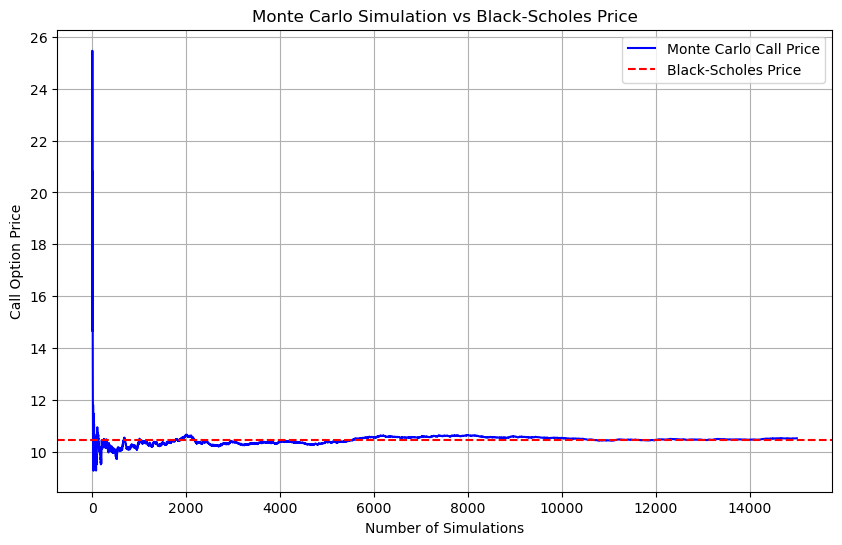

In [19]:
black_scholes_price = black_scholes_call(S0, K, r, sigma, T, q)
x_values, y_values, monte_carlo_price, delta_estimate = monte_carlo_call(S0, K, r, sigma, T)
print(f"The Black-Scholes price of the call option is: {black_scholes_price:.5f}")
print(f"The Monte Carlo price of the call option is: {monte_carlo_price:.5f}")

percentage_difference = abs(black_scholes_price - monte_carlo_price) / black_scholes_price * 100
print(f"The percentage difference between Black-Scholes and Monte Carlo prices is: {percentage_difference:.5f}%")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Monte Carlo Call Price', color='blue')
plt.axhline(y=black_scholes_price, color='red', linestyle='--', label='Black-Scholes Price')
plt.title('Monte Carlo Simulation vs Black-Scholes Price')
plt.xlabel('Number of Simulations')
plt.ylabel('Call Option Price')
plt.legend()
plt.grid()
plt.show()

## Risk Management and the Greeks

Because of how complicated option pricing is, traders often rely on mathematical gauges called *Greeks* to see how different market conditions affect their options' positions. the main four used are Delta, Gamma, Theta and Vega.

| Market Change | Long Call | Short Call | Long Put | Short Put |
| ---- | ---- | ---- | ---- | ---- |
| Spot price rises | Profit | Loss | Loss | Profit |
| Volatility increses | Profit | Loss | Profit | Loss |
| Time decay | Loss | Profit | Loss | Profit |

### Delta

Delta shows how much an options price will change relative to a $1 move in the underlying asset's price. It is the probability that the option is ITM when the option expires. For hedging, delta tells us how much of the underlying asset to buy to remain risk neutral.

Its definition is:

\begin{equation*}
\Delta = \frac{\partial C}{\partial S}
\end{equation*}

Its ranges are:

- **Call option**: $ \Delta \in (0, 1) $
- **Put option**: $ \Delta \in (-1, 0) $
- ATM options: $ \Delta \approx \pm 0.5$
- Deep ITM call: $ \Delta \approx 1 $
- Deep OTM put: $ \Delta \approx 0 $

It is equal to $N(d_1)$ for a call option and $-N(-d_1)$ for a put.

### Gamma

Gamma shows how much an options delta will change relative to a \$1 move in the underlying asset's price and is the derivative of $\Delta$ with respect to spot price.

\begin{equation*}
\Gamma = \frac{\partial ^ 2 V}{\partial S^2} = \frac{\partial \Delta}{\partial S} = \frac{e^{-qT}}{S \sigma \sqrt{T}} N'(d_1)
\end{equation*}

where for a call option:

\begin{equation*}
N'(d_1) = \frac{1}{\sqrt{2 \pi}} e ^ {-\frac{1}{2}d_1^2}
\end{equation*}

It tells us the curvature of the price and how non-linear the option value is with respect to the spot. 

\begin{equation*}
\Gamma \in [0, \infty)
\end{equation*}

- Deep OTM: Gamma is near zero as it barely reacts to spot changes
- Deep ITM: Gamma is near zero as it behaves almost identical to the underlying.
- ATM: Gamma is at its highest as the Delta changes rapidly


- **Gamma increases** as time to expiry **decreases**, especially near ATM
- **Higher volatility** spreads gamma across strikes, reducing the peak
- Gamma is always **positive** for vanilla calls and puts under Black-Scholes
- Units: **change in delta per $1 change in spot**
- Important for risk: **high gamma = frequent re-hedging needed**

### Theta

Theta measures how the price of an option changes with respect to time-to-maturity.

\begin{equation*}
\Theta = \frac{\partial C}{\partial T}
\end{equation*}

For a call this is:

\begin{equation*}
\Theta_{call} = - \frac{S e^{-qT} N'(d_1) \sigma}{2 \sqrt{T}} + q S e^{-qT} N(d_1) - r K e^{-rT} N(d_2)
\end{equation*}

| Position    | Theta range   | Interpretation                        |
|-------------|---------------|---------------------------------------|
| Long Call   | $\Theta < 0$  | Loses value over time                 |
| Short Call  | $\Theta > 0$  | Gains value over time                 |
| Long Put    | $\Theta < 0$  | Loses value over time                 |
| Short Put   | $\Theta > 0$  | Gains value over time                 |
| ATM         | Most negative (for long) | Highest time decay happens ATM |
| Deep ITM    | Slightly negative (long) | Small time decay, less sensitive |
| Deep OTM    | Slightly negative (long) | Small time decay, less sensitive |

### Vega

Vega measures how the option's price changes with respect to volatility

\begin{equation*}
Vega = \frac{\partial C}{\partial \sigma} = Se^{-qT} \sqrt{T} N'(d_1)
\end{equation*}

where:  
$q$ is the dividend yield

| Position    | Vega range   | Interpretation                        |
|-------------|---------------|---------------------------------------|
| Long Call   | $Vega > 0$  | Gains value as volatility increases   |
| Short Call  | $Vega < 0$  | Loses value as volatility increases   |
| Long Put    | $Vega > 0$  | Gains value as volatility increases   |
| Short Put   | $Vega < 0$  | Loses value as volatility increases   |
| ATM         | Highest      | Vega is largest for at-the-money      |
| Deep ITM    | Lower        | Vega decreases as option moves ITM    |
| Deep OTM    | Lower        | Vega decreases as option moves OTM    |

Vega and volatility decreases as time to maturity decreases

### Rho

Rho measures how the option's price changes with respect to the risk free rate.

\begin{equation*}
\rho = \frac{1}{100} K T e^{-rT} N(d_2)
\end{equation*}

| Position    | Rho range         | Interpretation                                 |
|-------------|------------------|------------------------------------------------|
| Long call   | $\rho > 0$       | Gains value as rates increase                  |
| Short call  | $\rho < 0$       | Loses value as rates increase                  |
| Long put    | $\rho < 0$       | Loses value as rates increase                  |
| Short put   | $\rho > 0$       | Gains value as rates increase                  |
| ATM         | Moderate         | Rho is moderate for at-the-money options       |
| Deep ITM    | Highest (calls)  | Rho is largest for deep ITM calls              |
| Deep OTM    | Lowest           | Rho is smallest for deep OTM options           |

Rho tends to zero as time to maturity decreases

In [20]:
df = greeks(S0, K, r, sigma, T, 0) # black scholes greeks
print(df.to_markdown(index=False))

|    Delta |    Gamma |    Theta |   Vega |
|---------:|---------:|---------:|-------:|
| 0.636831 | 0.018762 | -6.41403 | 37.524 |


In [21]:
x_values, y_values, call_price, delta_estimate = monte_carlo_call(S0, K, r, sigma, T)
print(delta_estimate)

0.6341435335921981
